In [4]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Num GPUs Available:  1
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-04-22 20:07:59.767354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-22 20:07:59.881700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-22 20:07:59.882111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-22 20:07:59.916590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-22 20:07:59.917194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not op

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

2022-04-22 20:08:20.349717: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8302
2022-04-22 20:08:25.960321: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


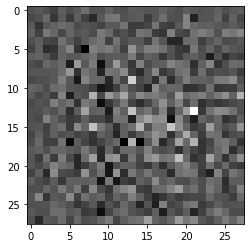

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00022228]], shape=(1, 1), dtype=float32)


In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-0.42110536,  0.7642155 , -0.9741567 , ..., -2.221127  ,
        -0.3887931 , -1.6600238 ],
       [-0.43193322, -0.23382719,  0.13557774, ..., -0.64501005,
        -0.54726356, -0.6953488 ],
       [-0.221081  , -1.8803835 ,  2.193909  , ...,  1.0961363 ,
        -0.19281699, -1.9526659 ],
       ...,
       [-0.42415056, -0.84102166, -0.24143122, ...,  1.9077442 ,
         0.1529678 , -0.11455376],
       [ 1.4337133 ,  0.4156551 , -0.11000419, ..., -0.20031483,
         1.3297279 ,  0.33382156],
       [-1.2449409 ,  1.0907309 ,  0.096423  , ...,  0.60249454,
        -1.0249944 , -0.35747662]], dtype=float32)>

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


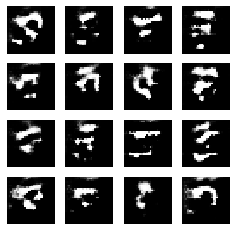

Time for epoch 10 is 53.66081380844116 sec


KeyboardInterrupt: 

In [24]:
train(train_dataset, EPOCHS)


In [30]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [35]:
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)


In [36]:
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)


tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [34]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [39]:
tf.test.is_built_with_cuda()

True

In [40]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [41]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 7s 0us/step


In [42]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [43]:
X_train[0].shape

(32, 32, 3)

In [44]:
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [45]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [46]:
y_train_encoded = keras.utils.to_categorical(y_train, num_classes = 10, dtype = 'float32')
y_test_encoded = keras.utils.to_categorical(y_test, num_classes = 10, dtype = 'float32')

In [47]:
def get_model():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(32,32,3)),
        keras.layers.Dense(3000, activation='relu'),
        keras.layers.Dense(1000, activation='relu'),
        keras.layers.Dense(10, activation='sigmoid')    
    ])
    model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [49]:
get_model().summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_5 (Dense)             (None, 3000)              9219000   
                                                                 
 dense_6 (Dense)             (None, 1000)              3001000   
                                                                 
 dense_7 (Dense)             (None, 10)                10010     
                                                                 
Total params: 12,230,010
Trainable params: 12,230,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%timeit -n1 -r1
# CPU
with tf.device('/CPU:0'):
    model_cpu = get_model()
    model_cpu.fit(X_train_scaled, y_train_encoded, epochs = 10)

Epoch 1/10
1563/1563 [==============================] - 105s 66ms/step - loss: 1.8113 - accuracy: 0.3538
Epoch 2/10
1563/1563 [==============================] - 111s 71ms/step - loss: 1.6196 - accuracy: 0.4289
Epoch 3/10
1563/1563 [==============================] - 110s 70ms/step - loss: 1.5397 - accuracy: 0.4546
Epoch 4/10
1563/1563 [==============================] - 112s 72ms/step - loss: 1.4795 - accuracy: 0.4799
Epoch 5/10
1563/1563 [==============================] - 113s 72ms/step - loss: 1.4298 - accuracy: 0.4974
Epoch 6/10
1563/1563 [==============================] - 113s 72ms/step - loss: 1.3899 - accuracy: 0.5133
Epoch 7/10
1563/1563 [==============================] - 112s 72ms/step - loss: 1.3491 - accuracy: 0.5247
Epoch 8/10
1563/1563 [==============================] - 113s 73ms/step - loss: 1.3182 - accuracy: 0.5376
Epoch 9/10
 523/1563 [=========>....................] - ETA: 1:18 - loss: 1.2844 - accuracy: 0.5519

In [ ]:
%%timeit -n1 -r1
# GPU
with tf.device('/GPU:0'):
    model_gpu = get_model()
    model_gpu.fit(X_train_scaled, y_train_encoded, epochs = 10)

In [ ]:
# loading dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
# checking shape

print(train_images.shape)

print(train_labels[0])

In [ ]:
# checking images
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.imshow(train_images[0])
class_names[train_labels[0]]

In [ ]:
# scaling
train_images_scaled = train_images / 255.0
test_images_scaled = test_images / 255.0


In [ ]:
def get_model(hidden_layers=1):
    # Flatten layer for input
    layers = [keras.layers.Flatten(input_shape=(28, 28))]
    # hideen layers
    for i in range(hidden_layers):
        layers.append(keras.layers.Dense(500, activation='relu'),)
    # output layer    
    layers.append(keras.layers.Dense(10, activation='sigmoid'))
    model = keras.Sequential(layers)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
%%timeit -n1 -r1
with tf.device('/CPU:0'):
    cpu_model = get_model(hidden_layers=5)
    cpu_model.fit(train_images_scaled, train_labels, epochs=5)

In [ ]:
%%timeit -n1 -r1
with tf.device('/GPU:0'):
    gpu_model = get_model(hidden_layers=5)
    gpu_model.fit(train_images_scaled, train_labels, epochs=5)